In [1]:
import numpy as np
import timeit
import math
import matplotlib.pyplot as plt
import copy

### XYZ to LAMMPS Input

In [2]:
#Load XYZ file
xyz_file = r"./salt_3UC.xyz"
species = np.loadtxt(xyz_file, skiprows = 2, usecols = (0,), dtype = str)
posns = np.loadtxt(xyz_file, skiprows = 2, usecols = (1,2,3))
N_atoms = len(species)
print(N_atoms)

216


In [3]:
species_map = {"Na" : 1, "Cl" : 2}
charge_map = {"Na" : 1, "Cl" : -1}

In [4]:
lammps_file = r"./salt3UC.positions"
with open(lammps_file, "a") as f:
    for i in range(N_atoms):
        f.write(f"{i+1} {species_map[species[i]]} {charge_map[species[i]]} {posns[i,0]} {posns[i,1]} {posns[i,2]} 0 0 0\n")
    
    f.write("\nVelocities\n\n")
    for i in range(N_atoms):
        f.write(f"{i+1} 0 0 0\n")

### Time B-Spline Functions

In [56]:

def M(u, n):
    if n > 2:
        return (u/(n-1))*M(u,n-1) + ((n-u)/(n-1))*M(u-1,n-1)
    elif n == 2:
        if u >= 0 and u <= 2:
            return 1 - np.abs(u-1)
        else:
            return 0
    else:
        print("Shouldn't be here")

#equivalent, time to see whats faster
def M2(u, n):
    return (1/math.factorial(n-1)) * np.sum([((-1)**k)*math.comb(n,k)*np.power(max(u-k, 0), n-1) for k in range(n+1)])


n = 5
u_vals = 7*np.random.random((4000,))

m1 = np.array([M(u_vals[i],n) for i in range(len(u_vals))])
m2 = np.array([M2(u_vals[i], n) for i in range(len(u_vals))])
print(np.sum(m1 - m2))

-3.418684928669254e-13


In [57]:
# num_iterations = 100 #timeit is a fucking garbage library
# execution_time = timeit.Timer(M(u,4), number=num_iterations)
# execution_time2 = timeit.Timer(M2(u,4), number=num_iterations)


# # Calculate average execution time
# average_execution_time = execution_time / num_iterations
# print(average_execution_time)
# average_execution_time2 = execution_time2 / num_iterations
# print(average_execution_time2)

### Charge Interpolation 2D

In [2]:
a = 2
lat_vecs = np.array([[a,0],[0,a]])
rec_lat_vecs = np.array([[1/a,0],[0,1/a]])

n = 4 #spline interpolation order
K1 = 20
K2 = 20

mesh_dims = np.array([K1,K2])

charges = [-1,1,1,-1]
r = np.array([[0.5,0.5], [1.5,0.5], [0.5,1.5], [1.5,1.5]])
u = np.zeros_like(r)

for i in range(len(charges)):
    for dim in range(2):
        u[i,dim] = np.dot(mesh_dims[dim]*rec_lat_vecs[dim], r[i,:])


In [99]:
# n_atoms = len(charges)
# M_coeffs = np.zeros((n_atoms, 2, n + 1))

# for i in range(n_atoms):
#     for dim in range(2):
#         for j in range(n+1):
#             M_coeffs[i,dim,j] = M(u[i,dim] - j, n)

In [100]:
# Q = np.zeros((K1,K2))
        
# #Full eqn -- the inner loop doesnt need to be over all K1,K2 just n^3 NN
# for k1 in range(K1):
#     for k2 in range(K2):
        
#         for i in range(len(charges)):

#             for p1 in range(K1):
#                 for p2 in range(K2):
#                     Q[k1, k2] += charges[i] * M(u[i,0] - k1 - p1*K1, n) * M(u[i,1] - k2 - p2*K2, n)

In [3]:
#straight copying from https://github.com/jht0664/structurefactor_spme/blob/master/run_sq.py#L274
def b_spline(u,n):
    # define m2 for n-1 values
    mn=np.zeros((n,n))
    for i in range(1,n):
        ui = u - np.float_(i-1)
        if (ui < 0.0) or (ui > 2.0):
            mn[1,i] = 0.0
        else:
            mn[1,i] = 1.0 - np.abs(ui - 1.0)
    # define mj recursively for n-1-(j-1) values
    for j in range(2,n):
        for i in range(1,n-j+1):
            ui = u - np.float_(i-1)
            mn[j,i]=(ui/np.float_(j))*mn[j-1,i]+((np.float_(j+1)-ui)/np.float_(j))*mn[j-1,i+1]
    return mn[n-1,1]

spline_grid = 100000 #resolution to pre-calculate b-splines
b_spline_arr = np.empty(spline_grid)
for i in range(spline_grid):
    b_spline_arr[i] = b_spline(n/np.float_(spline_grid)*np.float_(i+1),n)

In [4]:
def grid_Q(xyz,K,n,n_grid,bo_spline):
	out_q = np.zeros((K,K))
	n_atom=np.shape(xyz)[0]
	u = np.empty(2)
	arg = np.empty(2) # distance between (original pt - nearpt), adding one element from range(spline_order)
	for j in range(n_atom):
		u=xyz[j]
		nearpt=np.int_(np.floor(u))
		# only need to go to k=0,n-1, for k=n, arg > n, so don't consider this
		for k1 in range(n):
			n1 = nearpt[0]-k1
			arg[0] = u[0]-np.float_(n1)
			# shift index of array storage if < 0
			n1 = np.mod(n1,K)
			for k2 in range(n):
				n2 = nearpt[1]-k2
				arg[1] = u[1]-np.float_(n2)
				n2 = np.mod(n2,K)
				splindex = np.ceil(arg/n*np.float_(n_grid))
				splindex = np.int_(splindex) 
				# note 0<arg<n , so arg should always be within bounds of gridded spline
				# we assume spline_order is 6
				sum = charges[j]*bo_spline[splindex[0]]*bo_spline[splindex[1]]
				out_q[n1,n2] = out_q[n1,n2] + sum
	return copy.copy(out_q)

Q = grid_Q(u, K1, n, spline_grid, b_spline_arr)


(0.0, 19.0)

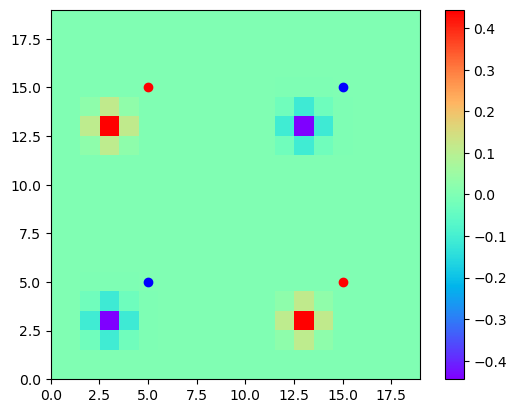

In [5]:
plt.imshow(Q, origin = "lower", cmap = "rainbow")
plt.colorbar()
colors = {-1 : 'b', 1 : 'r'}
for i in range(len(charges)):
    plt.scatter(u[i,0],u[i,1], c = colors[charges[i]])

plt.xlim([0,K1-1])
plt.ylim([0,K2-1])